In [1]:
import pymongo as pm
from pprint import pprint
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing']
db.authenticate('ictts', 'Ictts16!')

permanentBookings = db['PermanentBookings']
permanentParkings = db['PermanentParkings']
enjoyPermanentBookings = db['enjoy_PermanentBookings']
enjoyPermanentParkings = db['enjoy_PermanentParkings']

In [2]:
start = datetime.fromisoformat('2017-01-01')
end = datetime.fromisoformat('2017-02-28')
city = "Vancouver"

In [3]:
# filter out: " booking origin = destination ", 
#             " booking duration less than 5 mins and greater than 4 hours ",
#             " parking duration less than 5 mins and greater than 6 hours ".

pipeline_booking_avg_std = [{"$match": {"city": city}},
                        {"$match": {"$and": [{"init_date": {"$gte": start}}, {"final_date": {"$lte": end}}]}},
                        {"$project": {"_id": 1, 
                                    "duration": {"$divide": [{"$subtract": ["$final_time", "$init_time"]}, 60]}, 
                                    "year": {"$dateToString": { "format": "%Y", "date": "$init_date" }},
                                    "month": {"$dateToString": { "format": "%m", "date": "$init_date" }},
                                    "day": {"$dateToString": { "format": "%d", "date": "$init_date" }},
                                    "hour": {"$dateToString": { "format": "%H", "date": "$init_date" }},
                                    "moved": {"$ne": [{"$arrayElemAt": [ "$origin_destination.coordinates", 0]},
                                                        {"$arrayElemAt": [ "$origin_destination.coordinates", 1]}]}}},
                        {"$match": {"$and": [{"moved": True}, {"duration": {"$gte": 5}}, {"duration": {"$lte": 3 * 60}}]}},
                        {"$group": {"_id": {"year":"$year","month":"$month","day":"$day"}, 
                                    "avg_duration": {"$avg": "$duration"},
                                    "std_duration":{"$stdDevPop":"$duration"}}
                                },
                        {"$sort": {"_id.year": 1,"_id.month":1,"_id.day":1}}     
                    ]
pipeline_parking_avg_std = [{"$match": {"city": city}},
                        {"$match": {"$and": [{"init_date": {"$gte": start}}, {"final_date": {"$lte": end}}]}},
                        {"$project": {"_id": 1, 
                                      "duration": {"$divide": [{"$subtract": ["$final_time", "$init_time"]}, 60]}, 
                                      "date": {"$dateToString": { "format": "%Y-%m-%d", "date": "$init_date" }},
                                      "hour": {"$dateToString": { "format": "%H", "date": "$init_date" }}}},
                        {"$match": {"$and": [{"duration": {"$gte": 5}}, {"duration": {"$lte": 3 * 60}}]}},
                        {"$group": {"_id": "$date", 
                                    "avg_duration": {"$avg": "$duration"},
                                    "std_duration":{"$stdDevPop":"$duration"}}
                                },
                        {"$sort": {"_id": 1}}   
                       ]
booking_avg_std = permanentBookings.aggregate(pipeline_booking_avg_std)
parking_avg_std = permanentParkings.aggregate(pipeline_parking_avg_std)


In [4]:
pipeline_booking_med_per = [{"$match": {"city": city}},
                        {"$match": {"$and": [{"init_date": {"$gte": start}}, {"final_date": {"$lte": end}}]}},
                        {"$project": {"_id": 1, 
                                    "duration": {"$divide": [{"$subtract": ["$final_time", "$init_time"]}, 60]}, 
                                    "date": {"$dateToString": { "format": "%Y-%m-%d", "date": "$init_date" }},
                                    "hour": {"$dateToString": { "format": "%H", "date": "$init_date" }},
                                    "moved": {"$ne": [{"$arrayElemAt": [ "$origin_destination.coordinates", 0]},
                                                        {"$arrayElemAt": [ "$origin_destination.coordinates", 1]}]}}},
                        {"$match": {"$and": [{"moved": True}, {"duration": {"$gte": 5}}, {"duration": {"$lte": 3 * 60}}]}},
                        # {"$sort": {"date": 1,"duration":1}}     
                    ]
pipeline_parking_med_per = [{"$match": {"city": city}},
                        {"$match": {"$and": [{"init_date": {"$gte": start}}, {"final_date": {"$lte": end}}]}},
                        {"$project": {"_id": 1, 
                                      "duration": {"$divide": [{"$subtract": ["$final_time", "$init_time"]}, 60]}, 
                                      "date": {"$dateToString": { "format": "%Y-%m-%d", "date": "$init_date" }},
                                      "hour": {"$dateToString": { "format": "%H", "date": "$init_date" }}}},
                        {"$match": {"$and": [{"duration": {"$gte": 5}}, {"duration": {"$lte": 3 * 60}}]}},
                        # {"$sort": {"date": 1,"duration":1}}     
                       ]
booking_med_per = permanentBookings.aggregate(pipeline_booking_med_per)
parking_med_per = permanentParkings.aggregate(pipeline_parking_med_per)

In [5]:
booking_map = {}
parking_map = {}
booking_med_map={}
booking_p90_map ={}
parking_med_map={}
parking_p90_map ={}
for booking in booking_med_per:
    try:
        temp = booking_map[booking["date"]]
        temp.append(booking["duration"])
        booking_map[booking["date"]]=temp
    except:
        temp = [booking["duration"]]
        booking_map[booking["date"]]=temp

for parking in parking_med_per:
    try:
        temp = parking_map[parking["date"]]
        temp.append(parking["duration"])
        parking_map[parking["date"]]=temp
    except:
        temp = [parking["duration"]]
        parking_map[parking["date"]]=temp

for key in booking_map.keys():
    a = np.array(booking_map[key])
    booking_med_map[key]=np.percentile(a,50)
    booking_p90_map[key]=np.percentile(a,90)

for key in parking_map.keys():
    a = np.array(parking_map[key])
    parking_med_map[key]=np.percentile(a,50)
    parking_p90_map[key] =np.percentile(a,90)
        

In [6]:
x_booking = []
y_booking_mean = []
y_booking_std = []
y_booking_med = []
y_booking_p90 = []

x_parking = []
y_parking_mean = []
y_parking_std = []
y_parking_med = []
y_parking_p90 = []

       
while booking_avg_std.alive:
    elem = booking_avg_std.next()
    key = elem["_id"]["year"]+"-"+elem["_id"]["month"]+"-"+elem["_id"]["day"]
    x_booking.append(key)
    y_booking_mean.append(elem["avg_duration"])
    y_booking_std.append(elem["std_duration"])
    y_booking_med.append(parking_med_map[key])
    y_booking_p90.append(parking_p90_map[key])
# for elem in booking_avg_std:
#     key = elem["_id"]["year"]+"-"+elem["_id"]["month"]+"-"+elem["_id"]["day"]
#     x_booking.append(key)
#     y_booking_mean.append(elem["avg_duration"])
#     y_booking_std.append(elem["std_duration"])
#     y_booking_med.append(parking_med_map[key])
#     y_booking_p90.append(parking_p90_map[key])

for elem in parking_avg_std:
    x_parking.append(elem["_id"])
    y_parking_mean.append(elem["avg_duration"])
    y_parking_std.append(elem["std_duration"])
    y_parking_med.append(parking_med_map[elem["_id"]])
    y_parking_p90.append(parking_p90_map[elem["_id"]])


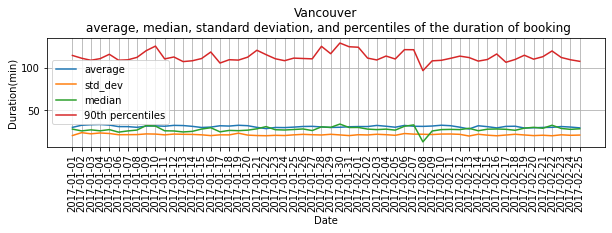

In [7]:
plt.figure(figsize=(10, 2))
plt.plot(y_booking_mean, label = 'average')
plt.plot(y_booking_std, label = 'std_dev')
plt.plot(y_booking_med, label = 'median')
plt.plot(y_booking_p90, label = '90th percentiles')
temp_date = ''
x = []
temp_loc = 0
for elem in x_booking:
    x.append(temp_loc)
    temp_loc += 1
plt.xticks(x,x_booking)
plt.grid()
plt.legend()
plt.title(city+"\n average, median, standard deviation, and percentiles of the duration of booking")
plt.xlabel('Date')
plt.ylabel('Duration(min)')
plt.xticks(rotation=90)
plt.show()

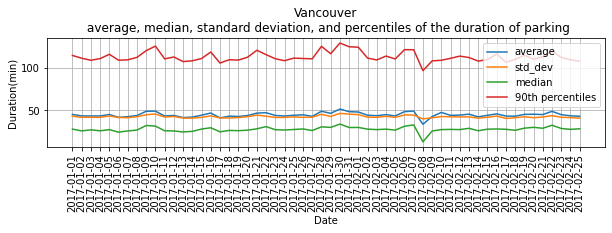

In [8]:
plt.figure(figsize=(10, 2))
plt.plot(y_parking_mean, label = 'average')
plt.plot(y_parking_std, label = 'std_dev')
plt.plot(y_parking_med, label = 'median')
plt.plot(y_parking_p90, label = '90th percentiles')
temp_date = ''
x = []
temp_loc = 0
for elem in x_parking:
    x.append(temp_loc)
    temp_loc += 1
plt.xticks(x,x_parking)
plt.grid()
plt.legend()
plt.title(city+"\n average, median, standard deviation, and percentiles of the duration of parking")
plt.xlabel('Date')
plt.ylabel('Duration(min)')
plt.xticks(rotation=90)
plt.show()